In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My\ Drive/Colab\ Notebooks/AMLProject/FashionMNIST

/content/drive/My Drive/Colab Notebooks/AMLProject/FashionMNIST


In [0]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch


**Parameters for GAN**

In [0]:
os.makedirs("images",exist_ok=True)

n_epochs = 200            # number of epochs of training 
batch_size = 64           # size of batches
lr = 0.0002               # adam: learning rate
b1 = 0.5                  # adam: decay of first order momentum
b2 = 0.999                # adam: decay of first order momentum
n_cpu = 8                 # number of cpu threads
latent_dims = 100         # dimension of latent space
img_size = 28             # size of image -> img_size x img_size
channels = 1              # number of channels of the input image
sample_interval = 400    # interval between image samples

**Dataset**

In [0]:
# Configure data loader
os.makedirs("./data/fmnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=batch_size,
    shuffle=True,
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:00, 35879965.62it/s]                              


Extracting ./data/mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 484537.12it/s]
0it [00:00, ?it/s]

Extracting ./data/mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 16342195.48it/s]                             
8192it [00:00, 121253.55it/s]


Extracting ./data/mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
cuda = True if torch.cuda.is_available else False
img_shape = (channels,img_size,img_size)

**Defining the Generator network**

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dims, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

**Defining the Discriminator Network**

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [0]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    print("Using CUDA as backend")
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

Using CUDA as backend


**Optimizers**

In [0]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


**Training the GAN**

In [0]:
gen_losses = []
dis_fake_loss = []
dis_real_loss = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dims))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        gen_losses.append(g_loss.tolist())

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        dis_fake_loss.append(fake_loss.tolist())
        dis_real_loss.append(real_loss.tolist())
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        # Display Progress every few batches
        if (i) % 100 == 0: 
            print( "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)

[Epoch 0/200] [Batch 0/938] [D loss: 0.669422] [G loss: 0.681011]
[Epoch 0/200] [Batch 100/938] [D loss: 0.370594] [G loss: 1.086525]
[Epoch 0/200] [Batch 200/938] [D loss: 0.299899] [G loss: 1.138654]
[Epoch 0/200] [Batch 300/938] [D loss: 0.267457] [G loss: 2.618410]
[Epoch 0/200] [Batch 400/938] [D loss: 0.266522] [G loss: 1.553779]
[Epoch 0/200] [Batch 500/938] [D loss: 0.525145] [G loss: 3.673900]
[Epoch 0/200] [Batch 600/938] [D loss: 0.333033] [G loss: 1.860024]
[Epoch 0/200] [Batch 700/938] [D loss: 0.395991] [G loss: 0.815479]
[Epoch 0/200] [Batch 800/938] [D loss: 0.311618] [G loss: 1.098471]
[Epoch 0/200] [Batch 900/938] [D loss: 0.259005] [G loss: 1.341440]
[Epoch 1/200] [Batch 0/938] [D loss: 0.231357] [G loss: 2.035705]
[Epoch 1/200] [Batch 100/938] [D loss: 0.211742] [G loss: 2.244624]
[Epoch 1/200] [Batch 200/938] [D loss: 0.231283] [G loss: 1.873415]
[Epoch 1/200] [Batch 300/938] [D loss: 0.249658] [G loss: 1.965421]
[Epoch 1/200] [Batch 400/938] [D loss: 0.353834] [G 

In [0]:
import pickle
# saving all the losses on disk
with open('gen_loss.pkl', 'wb') as fp:
    pickle.dump(gen_losses, fp)
    
with open('dis_fake_loss.pkl', 'wb') as fp:
    pickle.dump(dis_fake_loss, fp)
    
with open('dis_real_loss.pkl', 'wb') as fp:
    pickle.dump(dis_real_loss, fp)



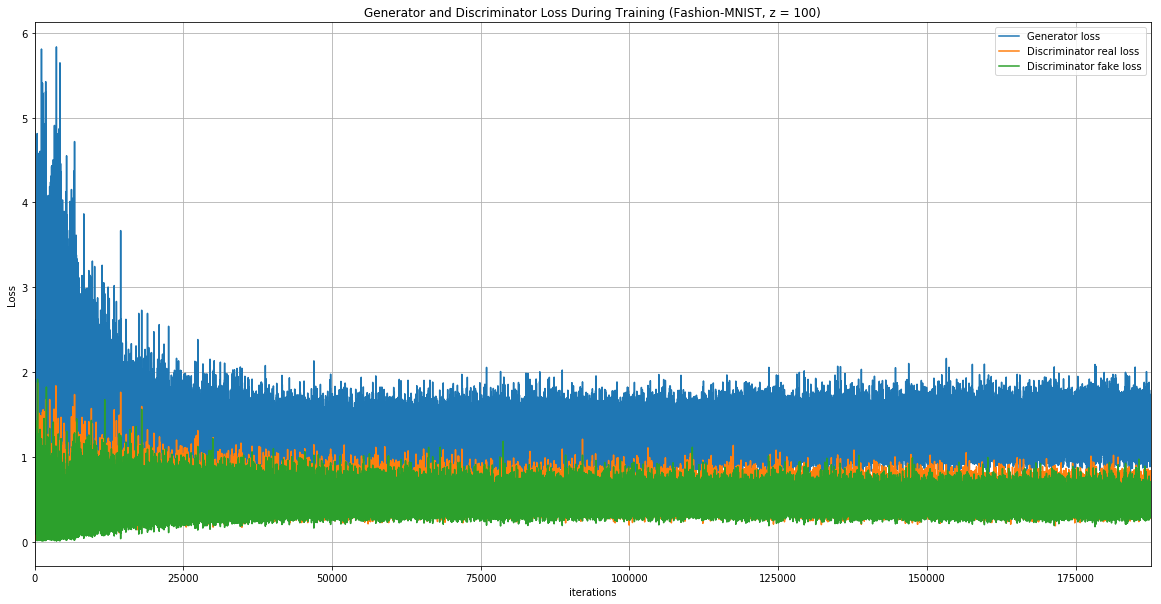

In [0]:

import matplotlib.pyplot as plt
with open('gen_loss.pkl', 'rb') as f:
    gen_loss = pickle.load(f)
    
with open('dis_real_loss.pkl', 'rb') as f:
    dis_real_loss = pickle.load(f)
    
with open('dis_fake_loss.pkl', 'rb') as f:
    dis_fake_loss = pickle.load(f)
    
    
plt.figure(figsize=(20,10))
plt.title("Generator and Discriminator Loss During Training (Fashion-MNIST, z = 100)")
plt.plot(gen_loss,label="Generator loss")
plt.plot(dis_real_loss,label="Discriminator real loss")
plt.plot(dis_fake_loss,label="Discriminator fake loss")
plt.xlim([1,187600])
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig('FMNISTloss.png')
plt.show()
